In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import tqdm
import pandas as pd

import sys
sys.path.append('./../..')
from dynaphos import utils

In [4]:
# plt.rcParams.update({
#     'axes.labelsize': 'large',
#     'font.size': 18,
#     'lines.linewidth': 2.5})
    
# # plt.rcParams.update({'style': 'seaborn'})

# dark_plots = False
# if dark_plots:
#     plt.style.use('dark_background')
#     neutral_color = 'w'
# else:
#     neutral_color = 'k'

# #colors for plots, to fit with theme for prettiness
# color1 = '#326e5e' #dark-turquoise
# color2 = '#63c4ab' #turquoise
# color3 = '#AFE4DE'

# c_list_turq = [color1,color2,color3]

# #donders color scheme
# color1 = '#8b0203' #dark red
# color2 = '#ba1319' #medium red
# color3 = '#ed1c24' #light red
# color4 = '#dd8a8d' #very light red (light red low opacity)

# c_list_red = [color1,color2,color3,color4]


COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')
plt.style.use('../_figurestyle/small.mplstyle')

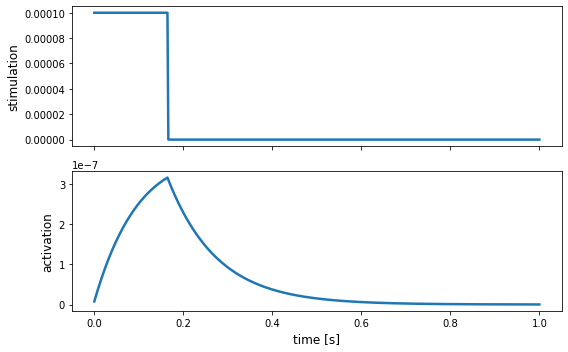

In [3]:
def run_experiment(X_IN,
                trace_decay_constant = -np.log( 0.999469),
                trace_increase_rate = 12.212884,
                act_decay_constant = 9, #21.,
                rheobase = 23.9e-6,
                pulse_width = 100e-6,
                frequency = 200,
                dt = 1/32,):
    
    # Stimulation sequence
    stim = X_IN.copy()
    n_steps = len(stim)
    T = n_steps*dt

    # Initialize output arrays
    stim_input = np.zeros(n_steps) # JR: effective stimulation
    trace = np.zeros(n_steps) #long-term memory trace
    activation = np.zeros(n_steps) #output
    leak = np.zeros(n_steps)

    
    activation_ = 0
    trace_ = 0.
    
    #run experiment
    for t in range(n_steps):
        
        ## TODO: REMOVE!!!
#         trace = np.zeros(n_steps) 
        
        
        if t>0:
            # remainder after decay from previous time step
            activation[t] = activation[t-1]
            activation[t] -= act_decay_constant * activation[t-1] * dt

            # new input
            leak_current  = trace[t-1] + rheobase
            stim_input[t] = (stim[t] - leak_current) * pulse_width * frequency 
            stim_input[t] = max(0,stim_input[t]) 
            activation[t] += stim_input[t] * dt 

            # trace update 
            trace[t] = trace[t-1]
            trace[t] -= trace_decay_constant * trace[t-1] * dt
            trace[t] += trace_increase_rate * stim_input[t] * dt
            
            leak[t]  = leak_current
            
        else:
            # In the first frame, ignore the previous time step (there is none)
            stim_input[t] = (stim[t] - rheobase) * pulse_width * frequency * dt 
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t]
            
            leak[t]  = rheobase
    
    return activation, trace, stim #, stim_input, leak


    
FPS = 500
STIM_SEQUENCE = np.concatenate([np.ones(83), np.zeros(417)]) # 1-second sequence of which the first .166 seconds are active

# Visualize example
activation, trace, stim = run_experiment(STIM_SEQUENCE * 100e-6,  pulse_width = 170e-6, frequency = 300,dt=1/FPS)
time = np.linspace(0,1,len(STIM_SEQUENCE))

fig,axs = plt.subplots(2,1, sharex=True, figsize=(8,5))
axs[0].plot(time, STIM_SEQUENCE* 100e-6)
axs[0].set(ylabel='stimulation')
axs[1].plot(time,activation)
axs[1].set(ylabel='activation', xlabel='time [s]')
plt.tight_layout()

In [4]:
## The simulator model
def amplitudes2activations(amplitudes,                       
                           pulse_width = 170e-6,
                           frequency = 300,
                           rheobase = 23.9e-6,
                           dt = 1/FPS):
    
    max_activations = np.zeros_like(amplitudes)
    for i, amp in enumerate(amplitudes):
        activation, trace, stim = run_experiment(STIM_SEQUENCE * amp,
                       pulse_width = pulse_width,
                       frequency = frequency,
                       rheobase = rheobase,
                       dt = dt)

        max_activations[i] = activation.max()
    return max_activations

## Brigtness functions
def stretched_exponential(activation,a, b):
    """Weibull stretched exponential function
    (starts at 0 and looks like sigmoid)"""
    y = 1-np.exp(-(activation*a)**b)
    return y # /y.max()

sigmoid = lambda x: 1/(1+np.exp(-x))
def sigmoidal_curve(activation,slope, I_half):
    """Standard sigmoidal curve, with offset and slope"""
    y = sigmoid(slope*(activation - I_half))
    return y # /y.max()

19152642.438042317 1.0576313268881034e-07
R^2: 0.9750941694379144


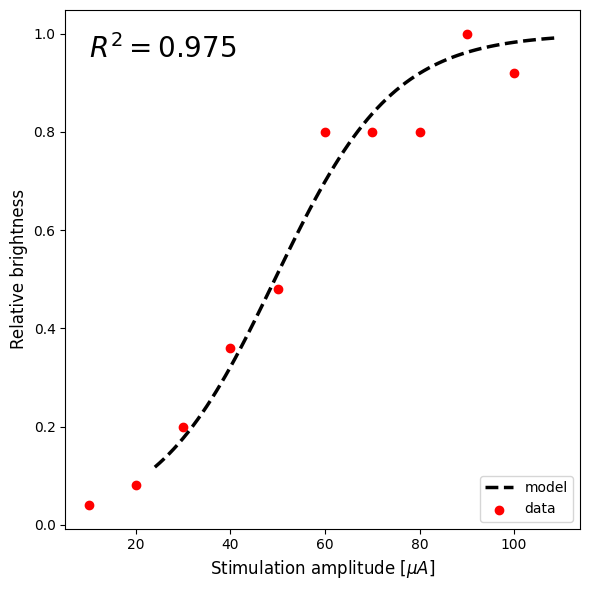

In [5]:
## Regression/simulation options
FANCY_SIGMOID = False   # if set to True, it uses the Weibull stretched exponential
IGNORE_ZERO_ACTIVATIONS = True # if set to true, only when the activation is non-zero the brightness is used for the regression.
RHEOBASE = 23.9e-6 # Default: 23.9e-6

#data Berna fig. 6A
data = pd.read_csv('data/Fernandez_2021_fig6A.csv')


# CURVE FITTING
if FANCY_SIGMOID:
    brightness_func = stretched_exponential
else:
    brightness_func = sigmoidal_curve

x_ = amplitudes2activations(data.amplitude)
y_ = data.brightness
res, cov = curve_fit(brightness_func,
                     x_, 
                     y_,
                     p0=[3e7,5e-8] ,
                     bounds= ([0,0],
                              [1e8,1e9]))
slope_fit, half_fit = res
print(slope_fit, half_fit)


## Visualization

# 1. The original datapoints 
x = data.amplitude
pred_activations = amplitudes2activations(x, rheobase=RHEOBASE)
y_pred = brightness_func(pred_activations, *res)
y_true = data.brightness

# 2. More datapoints sampled with the fitted curve
x_interpolated = np.arange(10,110,1)*1e-6
activations_interpolated = amplitudes2activations(x_interpolated,rheobase=RHEOBASE)
y_pred_interpolated = brightness_func(activations_interpolated, *res)

# 3. Calculate R-squared and plot figures
fig, ax = plt.subplots(1,1,figsize = (6,6), dpi=100)

if IGNORE_ZERO_ACTIVATIONS:
    regres = linregress(y_true[pred_activations!=0],y_pred[pred_activations!=0]) # Only regress over non-zero activations
    ax.plot(x_interpolated[activations_interpolated!=0]*1e6,y_pred_interpolated[activations_interpolated!=0], 'k--', label='model')
else:
    regres = linregress(y_true,y_pred)
    ax.plot(x_interpolated*1e6,y_pred_interpolated, 'k--', label='model')
print(f"R^2: {regres.rvalue}")

ax.scatter(x*1e6,y_true, label= 'data', c=['r'])
ax.set(xlabel='Stimulation amplitude [$\mu A$]',
       ylabel='Relative brightness')
ax.legend(loc='lower right')
ax.text(10,0.95,f'$R^2 = {regres.rvalue:0.3f}$',
            bbox={'color':'white','fill':True},
            fontsize = 20, horizontalalignment = 'left')
plt.tight_layout()

## Verify using simulator model

In [22]:
import sys
sys.path.append('./../..')
from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map, get_visual_field_coordinates_probabilistically 


import torch


from tqdm import tqdm_notebook

import pandas as pd
import seaborn as sns


In [25]:
params = utils.load_params('../../config/params.yaml')

# Testing with few phosphenes:
params['cortex_model']['dropout_rate'] = 0

# TODO use params from schmidt: F = 200 Hz, PD =100 us, IPI = 100 us, TL = 125 ms

# params['thresholding']['rheobase'] = 0 #23.9e-6
params['default_stim']['pw_default'] = 170e-6
params['default_stim']['freq_default'] = 300
params['run']['gpu'] = None

# params['brightness_saturation']['cps_half'] = 1.1290717738548107e-07
# params['brightness_saturation']['slope_brightness'] =  17940259.58571496


# Simulator 1
params['run']['fps'] = FPS
params['thresholding']['use_threshold'] = False
coordinates_visual_field = get_visual_field_coordinates_probabilistically(params,n_phosphenes=1)
simulator = PhospheneSimulator(params.copy(), coordinates_visual_field)
n_phosphenes = simulator.num_phosphenes

stim_amplitudes = data.amplitude
results = pd.DataFrame()
for stim_condition, amplitude in enumerate(stim_amplitudes):
    simulator.reset()
    states = []
    for i,stim in enumerate(STIM_SEQUENCE):
        simulator.update(torch.ones(n_phosphenes)*stim*amplitude)
        states.append({k:v.item() for k,v in simulator.get_state().items()})
        states[-1]['amplitude'] = stim*amplitude
        states[-1]['stim_condition'] = stim_condition
        states[-1]['time'] = i/FPS
        
    results = results.append(pd.DataFrame(states), ignore_index=True)

/tmp/ipykernel_15409/29545414.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(states), ignore_index=True)
/tmp/ipykernel_15409/29545414.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(states), ignore_index=True)
/tmp/ipykernel_15409/29545414.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(states), ignore_index=True)
/tmp/ipykernel_15409/29545414.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(states), ignore_index=True)
/tmp/ipykernel_15409/29545414.py:36: FutureWarni

In [26]:
colormapping = {0: np.array([0.93126922, 0.82019218, 0.7971481 , 1.        ]),
                1: np.array([0.89312209, 0.72061009, 0.72229577, 1.        ]),
                2: np.array([0.84811021, 0.62739325, 0.66767526, 1.        ]),
                3: np.array([0.78404409, 0.52926605, 0.62005689, 1.        ]),
                4: np.array([0.71124294, 0.44706244, 0.58215411, 1.        ]),
                5: np.array([0.61468483, 0.36475374, 0.53830539, 1.        ]),
                6: np.array([0.5151069 , 0.29801048, 0.49050619, 1.        ]),
                7: np.array([0.39630192, 0.23148835, 0.42265691, 1.        ]),
                8: np.array([0.28645868, 0.17570376, 0.34407541, 1.        ]),
                9: np.array([0.17508656, 0.11840023, 0.24215989, 1.        ])}

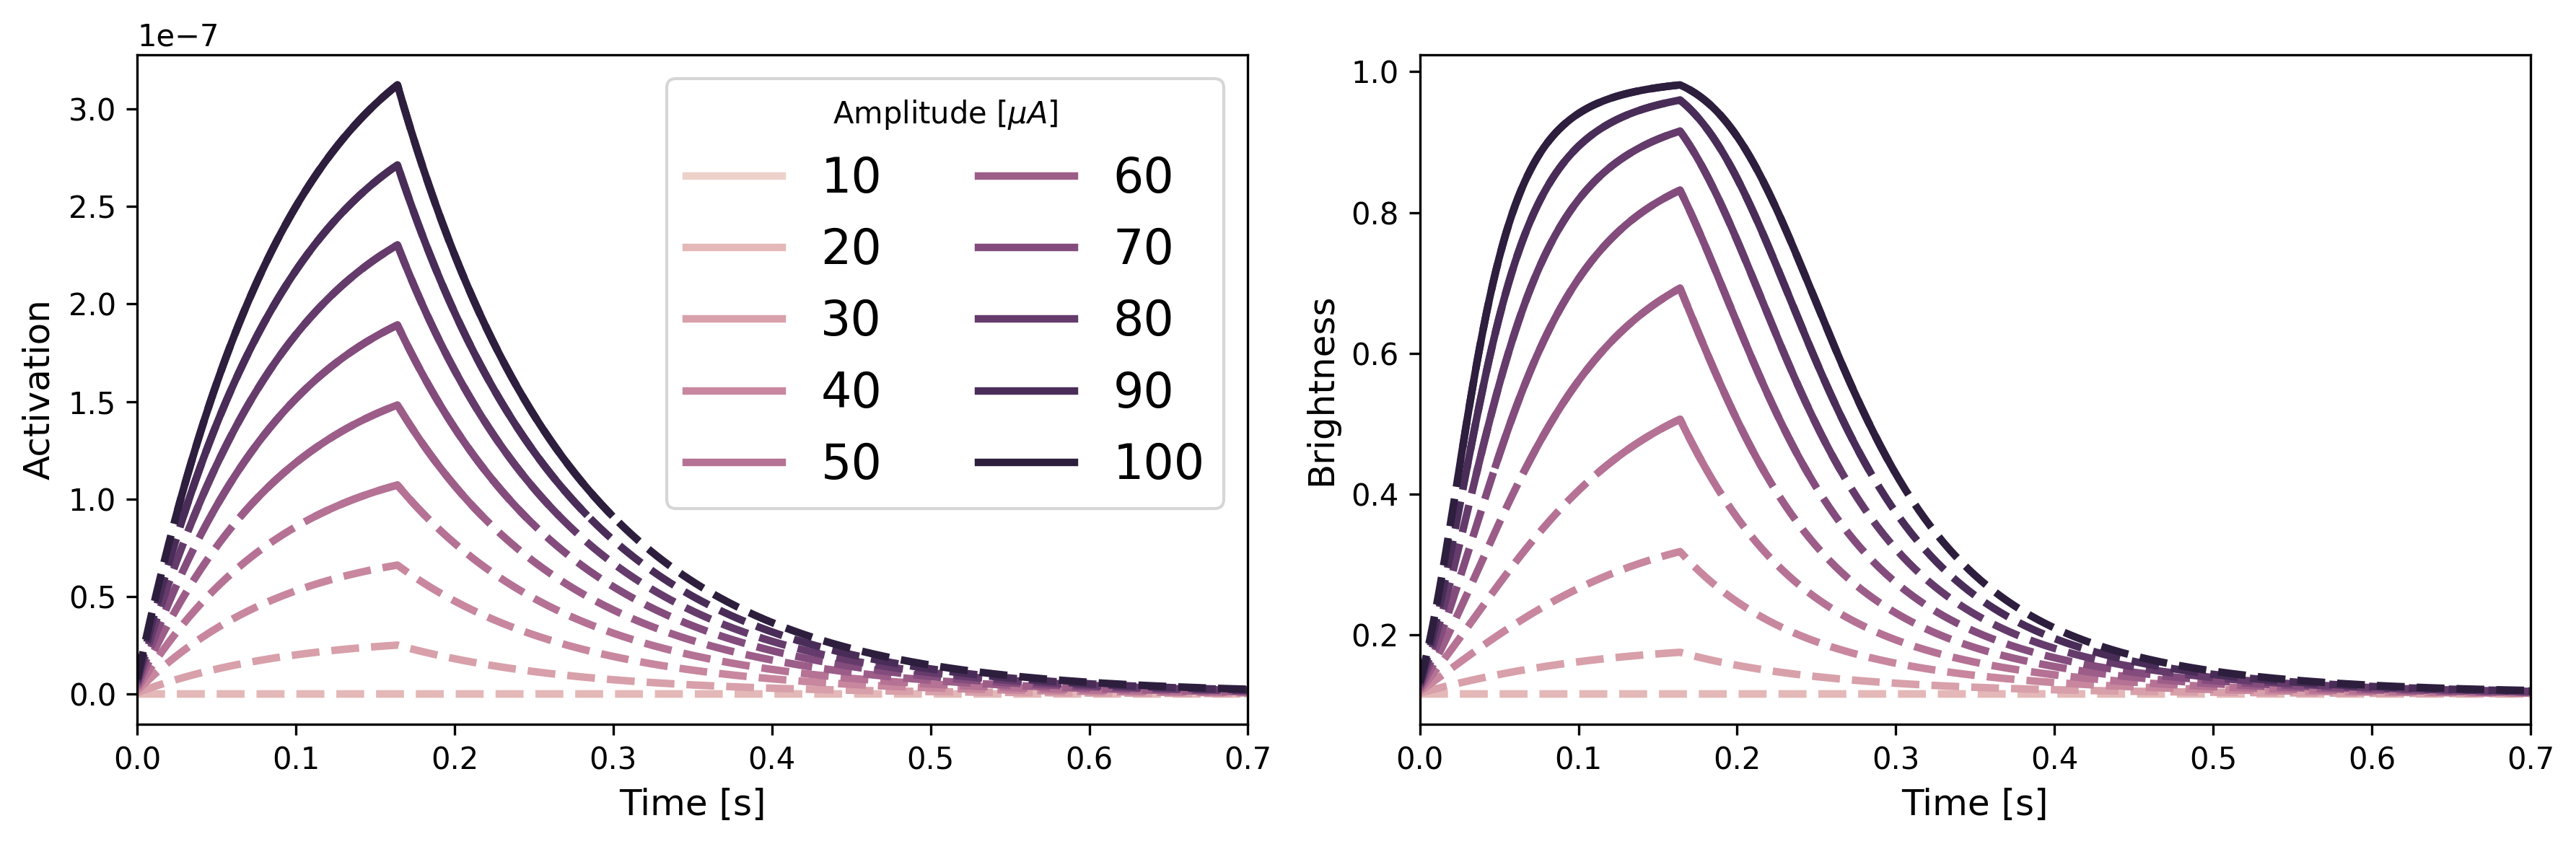

R^2: 0.9747507298452657


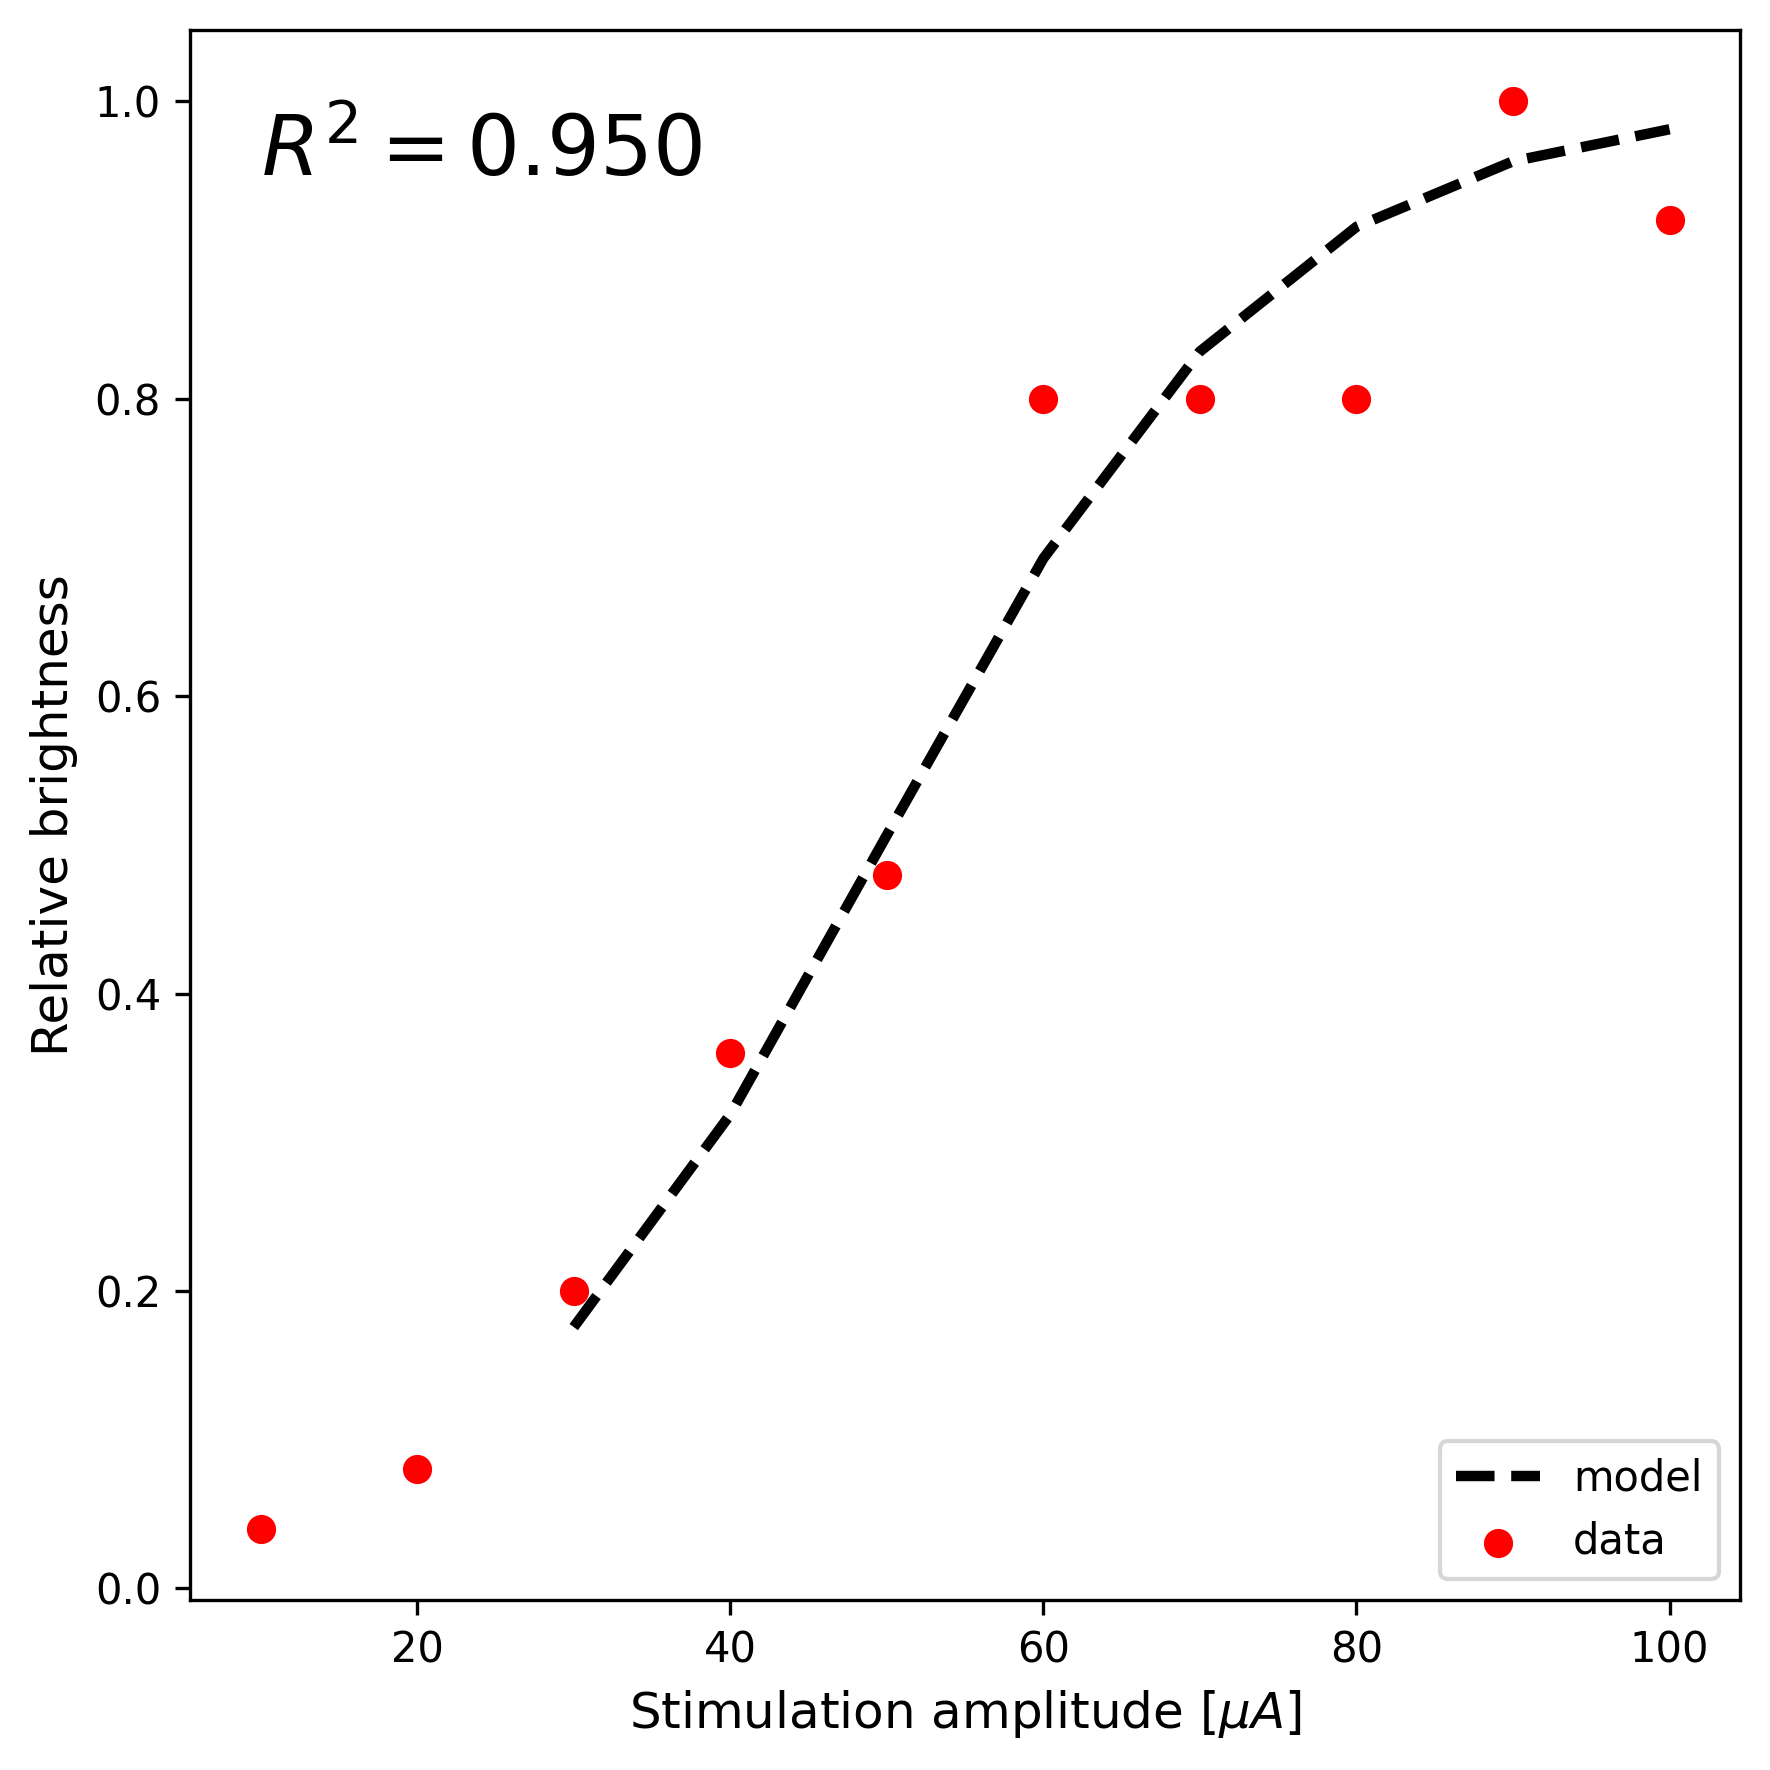

In [30]:
fig1, axs = plt.subplots(1,2, figsize=(12,4,),dpi=300)

# Plot dashed lines for all activations and brightnesses
sns.lineplot(data=results, x='time', y='activation', hue='stim_condition', ax=axs[0],legend=False, linestyle='--')
sns.lineplot(data=results, x='time', y='brightness',hue='stim_condition', ax=axs[1],legend=False, linestyle = '--')

# Plot full lines for above-threshold Activations
for condition,color in colormapping.items():
    data_ = results.loc[results.stim_condition==condition]
    mask  = data_.activation > params['thresholding']['activation_threshold']
    axs[0].plot(data_.time[mask], data_.activation[mask], color= color)
    axs[1].plot(data_.time[mask], data_.brightness[mask], color= color)


axs[0].set(xlim=[0,0.7],
           xlabel= 'Time [s]',
           ylabel='Activation',          )
axs[1].set(xlim=[0,0.7],
           xlabel= 'Time [s]',
           ylabel='Brightness',          )

axs[0].legend(axs[0].get_children()[10:20], 
              np.round(stim_amplitudes*1e6).astype(int),
              title='Amplitude [$\mu A$]', loc='upper right',
              prop={'size': 16},
              ncol=2)
plt.tight_layout()
plt.show()


# Find the peaks in activation and brightness for each stim_condition
brightness = []
activation = []
for i in results.stim_condition.unique():
    brightness.append(results.loc[results.stim_condition == i, 'brightness'].max())
    activation.append(results.loc[results.stim_condition == i, 'activation'].max())

x = stim_amplitudes
activation = np.array(activation)
y_pred = np.array(brightness)
y_true = data.brightness

# Regress and visualize

fig2, ax = plt.subplots(1,1,figsize = (6,6), dpi=300)
if IGNORE_ZERO_ACTIVATIONS:
    ax.plot(x[activation!=0]*1e6, y_pred[activation!=0],'k--', label='model')
    regres = linregress(y_true[activation!=0],y_pred[activation!=0]) # Only regress over non-zero activations
else:
    ax.plot(x*1e6, y_pred,'k--', label='model')
    regres = linregress(y_true,y_pred)
ax.scatter(x*1e6,y_true, label= 'data', c=['r'])
print(f"R^2: {regres.rvalue}")
ax.set(xlabel='Stimulation amplitude [$\mu A$]',
       ylabel='Relative brightness')
ax.legend(loc='lower right')
ax.text(10,0.95,f'$R^2 = {regres.rvalue**2:0.3f}$',
            bbox={'color':'white','fill':True},
            fontsize = 20, horizontalalignment = 'left')
plt.tight_layout()


In [36]:
fig1.savefig('results/Brightness_and_activation.png')
fig2.savefig('results/repro_Fernandez_et_al_2021_fig6A_brightness.png')

### Write output to csv files

In [38]:

# # Psychometric curve (max brightness)
# out = data.copy()
# out['brightness_estimate'] = y_pred
# out['tissue_activation_estimate'] = activation #pred_activations
# out.to_csv('results/brightness_estimate.csv', index = False)

# # Brightness and activation curves (full sequence)
# results.to_csv('results/brightness_and_activation_curves.csv')

# # Parameter estimates
# parameter_estimates = pd.Series({'slope': slope_fit,
#                                  'A50':  half_fit,
#                                  'r-squared':regres.rvalue**2}, name='parameter_estimates_sigmoid_brightness')
# parameter_estimates.to_csv('results/parameter_estimates.csv')


### Reload previously saved data

In [6]:
import pandas as pd 



data = pd.read_csv('results/brightness_estimate.csv')
y_pred, activation = data['brightness_estimate'], data['tissue_activation_estimate']

results = pd.read_csv('results/brightness_and_activation_curves.csv')

parameter_estimates = pd.read_csv('results/parameter_estimates.csv')


### Restyled figure

In [16]:
import sys
sys.path.append('./../..')
from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map, get_visual_field_coordinates_probabilistically 


import torch


from tqdm import tqdm_notebook

import pandas as pd
import seaborn as sns
params = utils.load_params('../../config/params.yaml')


data = pd.read_csv('results/brightness_estimate.csv')
y_pred, activation = data['brightness_estimate'], data['tissue_activation_estimate']

results = pd.read_csv('results/brightness_and_activation_curves.csv')

parameter_estimates = pd.read_csv('results/parameter_estimates.csv')

colormapping = {0: np.array([0.93126922, 0.82019218, 0.7971481 , 1.        ]),
                1: np.array([0.89312209, 0.72061009, 0.72229577, 1.        ]),
                2: np.array([0.84811021, 0.62739325, 0.66767526, 1.        ]),
                3: np.array([0.78404409, 0.52926605, 0.62005689, 1.        ]),
                4: np.array([0.71124294, 0.44706244, 0.58215411, 1.        ]),
                5: np.array([0.61468483, 0.36475374, 0.53830539, 1.        ]),
                6: np.array([0.5151069 , 0.29801048, 0.49050619, 1.        ]),
                7: np.array([0.39630192, 0.23148835, 0.42265691, 1.        ]),
                8: np.array([0.28645868, 0.17570376, 0.34407541, 1.        ]),
                9: np.array([0.17508656, 0.11840023, 0.24215989, 1.        ])}

plt.style.use('../_figurestyle/small.mplstyle')

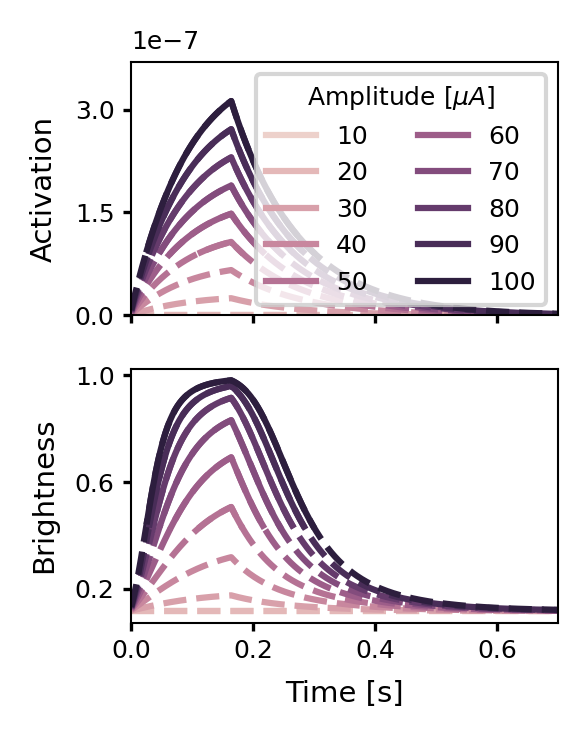

In [24]:
fig1, axs = plt.subplots(2,1, figsize=(2,2.5,), sharex=True ,dpi=300)

# Plot dashed lines for all activations and brightnesses
sns.lineplot(data=results, x='time', y='activation', hue='stim_condition', ax=axs[0],legend=False, linestyle='--')
sns.lineplot(data=results, x='time', y='brightness',hue='stim_condition', ax=axs[1],legend=False, linestyle = '--')

# Plot full lines for above-threshold Activations
for condition,color in colormapping.items():
    data_ = results.loc[results.stim_condition==condition]
    mask  = data_.activation > params['thresholding']['activation_threshold']
    axs[0].plot(data_.time[mask], data_.activation[mask], color= color)
    axs[1].plot(data_.time[mask], data_.brightness[mask], color= color)


axs[0].set(xlim=[0,0.7],
           xlabel= 'Time [s]',
           ylabel='Activation',    
           ylim = [0,3.7e-7],
           yticks=[0, 1.5e-7, 3e-7] #, 0.6, 1.]
           )
# axs[0].set(yticklabels=['{:.2E}'.format(t) for t in axs[0].get_yticks()])
axs[1].set(xlim=[0,0.7],
#            ylim=[0,1.1],
           xlabel= 'Time [s]',
           ylabel='Brightness',  
#            yticks=[0.2, 0.4, 0.6, 0.8, 1.],
           yticks=[0.2, 0.6, 1.]
          )

axs[0].legend(axs[0].get_children()[10:20], 
              np.round(data.amplitude*1e6).astype(int),
              title='Amplitude [$\mu A$]', loc='upper right',
              prop={'size': 6},
              
              ncol=2)
# axs[0].get_legend().get_title().set_fontsize('14')

plt.tight_layout()
plt.show()



In [86]:
fig1.savefig('results/Brightness_and_activation_vert.png')

R^2: 0.9747507298452657


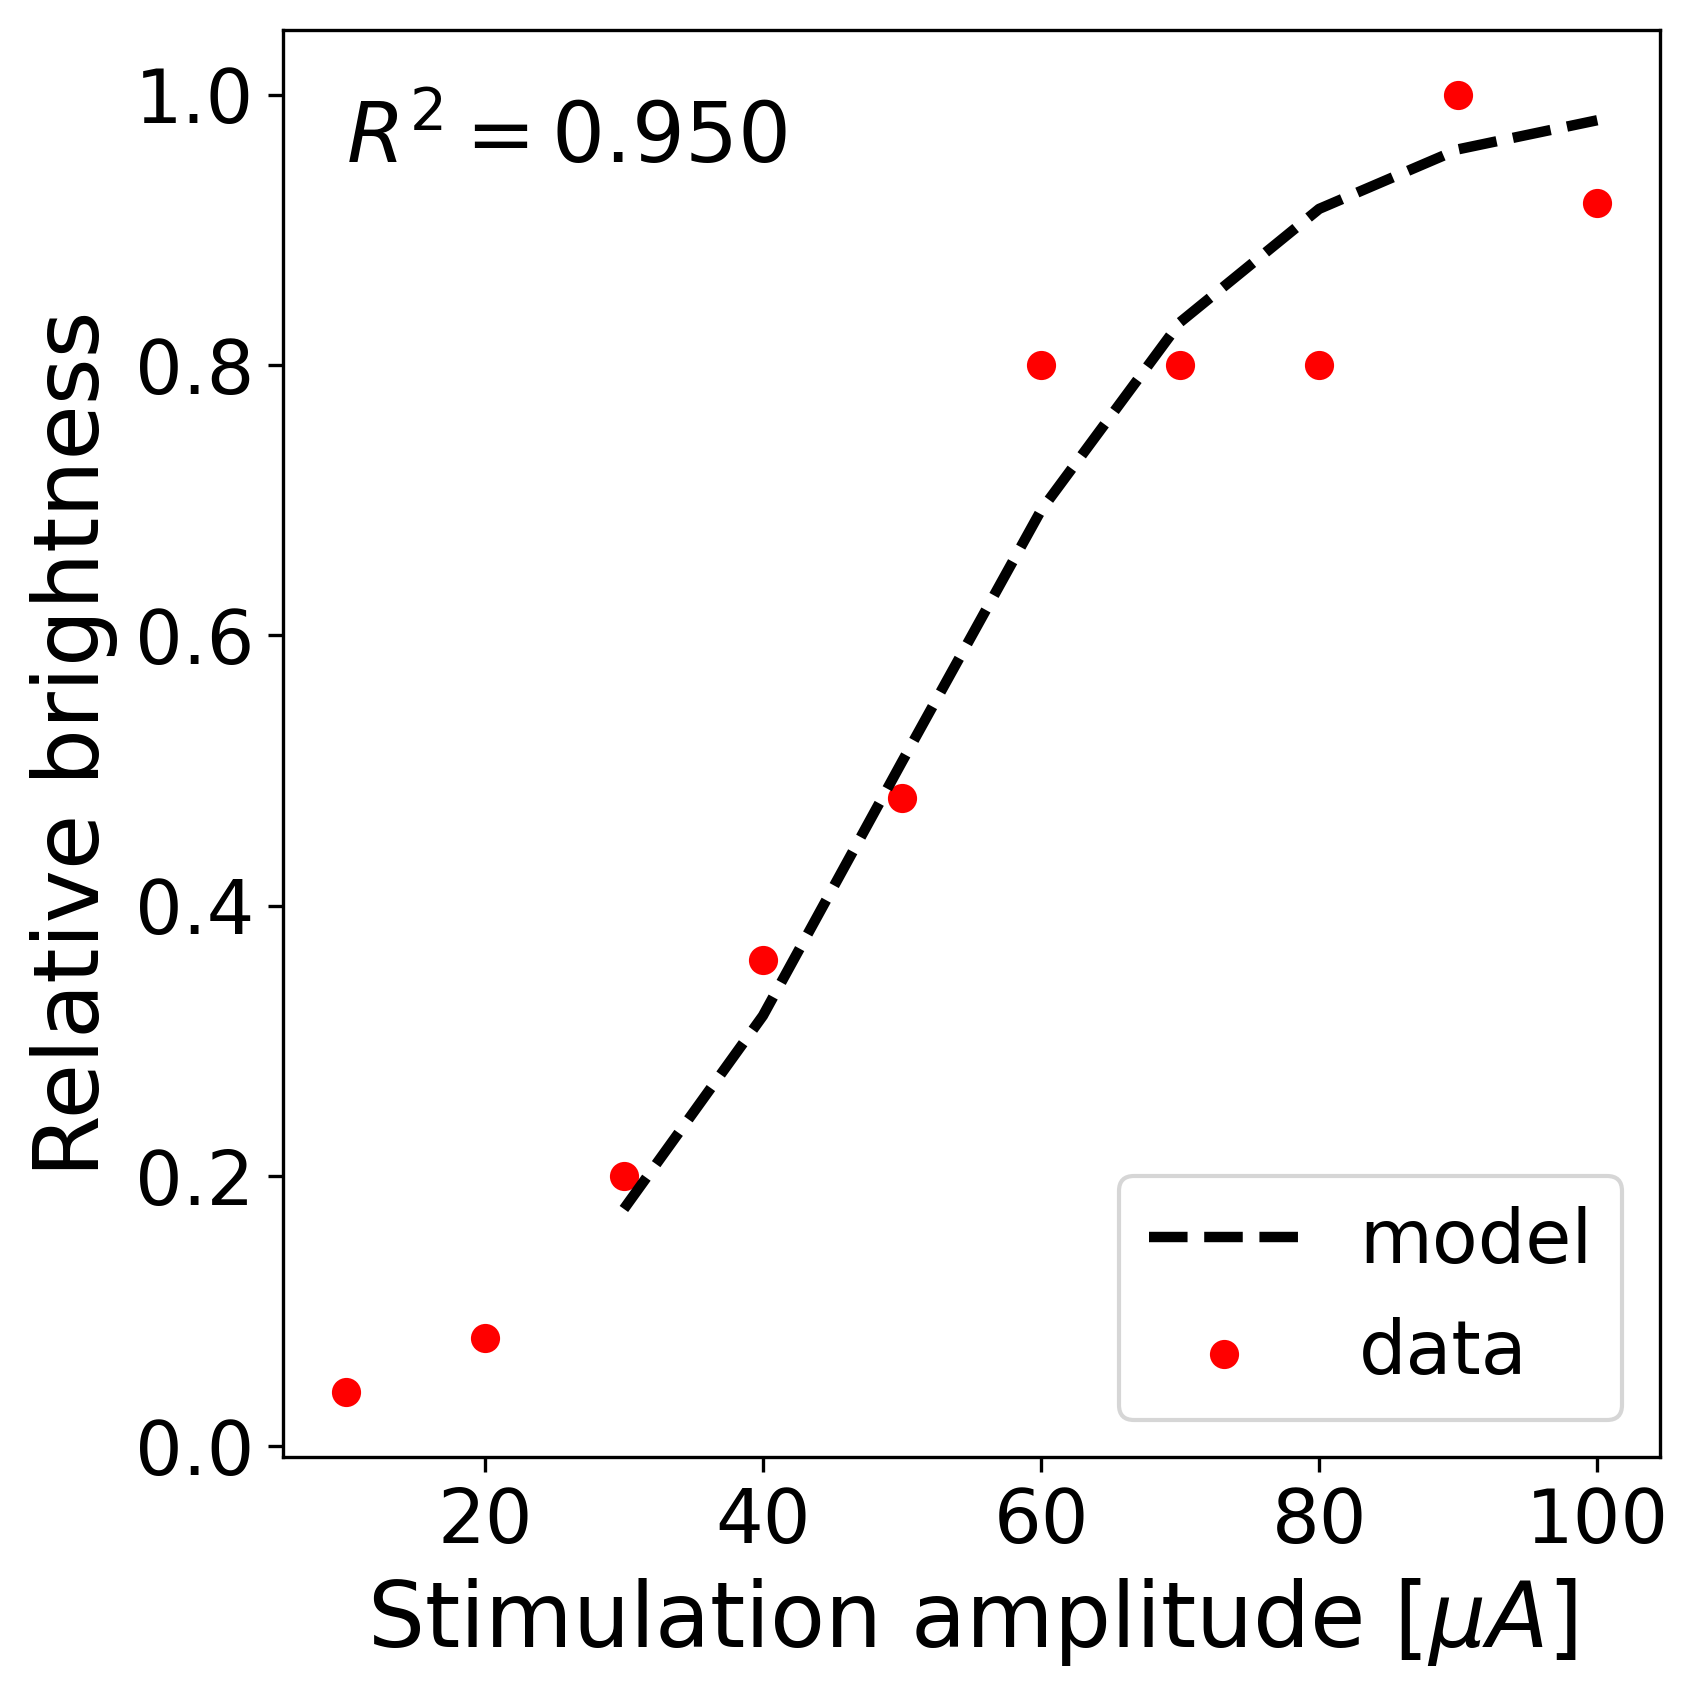

In [87]:

fig2, ax = plt.subplots(1,1,figsize = (6,6), dpi=300)
if IGNORE_ZERO_ACTIVATIONS:
    ax.plot(x[activation!=0]*1e6, y_pred[activation!=0],'k--', label='model')
    regres = linregress(y_true[activation!=0],y_pred[activation!=0]) # Only regress over non-zero activations
else:
    ax.plot(x*1e6, y_pred,'k--', label='model')
    regres = linregress(y_true,y_pred)
ax.scatter(x*1e6,y_true, label= 'data', c=['r'])
print(f"R^2: {regres.rvalue}")
ax.set(xlabel='Stimulation amplitude [$\mu A$]',
       ylabel='Relative brightness')
ax.legend(loc='lower right')
ax.text(10,0.95,f'$R^2 = {regres.rvalue**2:0.3f}$',
            bbox={'color':'white','fill':True},
            fontsize = 20, horizontalalignment = 'left')
plt.tight_layout()

In [88]:
fig2.savefig('results/repro_Fernandez_et_al_2021_fig6A_brightness.png')